In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### Zebra Finch vocalizations
Source:
- https://drive.google.com/drive/folders/1etvuPjaNHV9oFPgUAuLxP3bk1aWfj3Pl
- https://www.nature.com/articles/s41467-018-06394-9
- https://www.ncbi.nlm.nih.gov/pubmed/26581377

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import IPython
import seaborn as sns

In [3]:
from avgn_paper.signalprocessing import spectrogramming as sg

In [4]:
import pdb
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [5]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter
from datetime import datetime

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
call_dict = {
    "Ag": "Wsst or aggressive call",
    "Be": "Begging calls",
    "DC": "Distance call",
    "Di": "Distress call",
    "LT": "Long Tonal call",
    "Ne": "Nest call",
    "So": "Song",
    "Te": "Tet call",
    "Th": "Thuk call",
    "Tu": "Tuck call",
    "Wh": "Whine call",
}

### data locations

In [7]:
DSLOC = Path('/mnt/cube/Datasets/ZebraFinch/VocalizationBank/ZebraFinchVocalizationBank/')

In [8]:
WAVLIST = list((DSLOC).expanduser().glob('*/*.wav'))
len(WAVLIST), WAVLIST[0]

(3433,
 PosixPath('/mnt/cube/Datasets/ZebraFinch/VocalizationBank/ZebraFinchVocalizationBank/AdultVocalizations/BluRas07dd_110607-TukC-15.wav'))

In [9]:
wav_df = pd.DataFrame(
    columns=[
        "indv",
        "age",
        "recordingdate",
        "vocalization_type",
        "voc_type_full",
        "voc_num",
        "wav_loc",
        "vocdata",
        "rate",
        "voc_len",
    ]
)
for wl in tqdm(WAVLIST):
    if wl.stem[: len("Unknown")] == "Unknown":
        continue
    indv = wl.stem[:10]
    anno = wl.stem[11:].split("-")
    if len(anno) == 3:
        wdate, call_type_full, call_num = anno
    elif len(anno) == 2:
        wdate, call_type_full = anno[0].split("_")
        call_num = anno[1]
    elif len(anno) == 4:
        wdate = anno[0]
        call_type_full = "".join(anno[1:3])
        call_num = anno[3]
    wdate = datetime.strptime(wdate[:6], "%y%m%d")
    age = wl.parent.stem
    rate, data = load_wav(wl)
    wav_df.loc[len(wav_df)] = [
        indv,
        age,
        wdate,
        call_type_full[:2],
        call_type_full,
        call_num,
        wl,
        data,
        rate,
        len(data) / rate,
    ]

for idx, row in tqdm(wav_df.iterrows(), total=len(wav_df)):
    if len(np.shape(row.vocdata)) != 2:
        wav_df.at[idx, "vocdata"] = np.expand_dims(row.vocdata, axis=1)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileW

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileW

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [10]:
# subset only shorter calls
wav_df = wav_df[wav_df['vocalization_type'].isin(['Be', 'Ne', 'So', 'Wh','WC'])==False]

In [11]:
wav_df[:3]

indv                 age recordingdate vocalization_type  \
0  BluRas07dd  AdultVocalizations    2011-06-07                Tu   
1  GraGra0201  AdultVocalizations    2011-09-07                Th   
3  LblRed0613  AdultVocalizations    2011-12-02                DC   

  voc_type_full voc_num                                            wav_loc  \
0          TukC      15  /mnt/cube/Datasets/ZebraFinch/VocalizationBank...   
1        ThuckC      47  /mnt/cube/Datasets/ZebraFinch/VocalizationBank...   
3            DC      31  /mnt/cube/Datasets/ZebraFinch/VocalizationBank...   

                                             vocdata   rate   voc_len  
0  [[-14, 37], [-5, 55], [-22, 66], [-1, 88], [22...  44100  0.066689  
1  [[143, 115], [147, 84], [143, 78], [128, 116],...  44100  0.090930  
3  [[-106, -35], [-89, -52], [-108, -51], [-104, ...  44100  0.297914

In [15]:
wav_df.age.unique()

array(['AdultVocalizations', 'ChickVocalizations'], dtype=object)

In [16]:
len(wav_df)

2160

In [13]:
total_indv_vocs = pd.DataFrame(
    {indv: [np.sum(wav_df.indv == indv)] for indv in np.unique(wav_df.indv)}
).T.sort_values(by=0, ascending=False).T
total_indv_vocs

GraGra0201  HPiHPi4748  YelGre5275  WhiRas44dd  GreOra1817  YelOra2575  \
0         158         152         151         140         131         108   

   LblRed0613  WhiLbl0010  BluRas61dd  LblBla4548  ...  WhiBlu3414  \
0         107          95          84          81  ...          23   

   LblBlu1630  LblGre0000  LblBlu2028  LblRas1800  LblGre0001  RedRas3600  \
0          21          20          20          11          11          10   

   WhiBlu3615  WhiBlu3513  LblBlu1927  
0           7           6           2  

[1 rows x 39 columns]

In [243]:
indv_df = []
for indv in np.unique(wav_df.indv): 
    total_voc_types = pd.DataFrame(
        {type_: [np.sum(wav_df[wav_df.indv == indv].vocalization_type == type_)] for type_ in np.unique(wav_df.vocalization_type)}
    ).T.sort_values(by=0, ascending=False).T
    indv_df.append(total_voc_types)
indv_df = pd.concat(indv_df)
indv_df['Total'] = indv_df.sum(axis=1)
indv_df.index = [i[:4] for i in np.unique(wav_df.indv)]
indv_df = indv_df.sort_values(by='Total', ascending=False).T
indv_df['Total'] = indv_df.sum(axis=1)
indv_df

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


GraG  HPiH  YelG  WhiR  GreO  YelO  LblR  WhiL  BluR  LblB  ...  LblB  \
Ag       12    32     9     9    21     7    17    15    10     0  ...     0   
DC       41    29    38    30    24    47    36    26    35    44  ...     0   
Di        2     2     0     0     0     2     0     1     0     0  ...     0   
LT        0     0     0     0     0     0     0     0     0     0  ...    21   
Te       35    30    33    30    23    29    28    27    30    37  ...     0   
Th       47    29    42    45    45     0    18     0     0     0  ...     0   
Tu       21    30    29    26    18    23     8    26     9     0  ...     0   
Total   158   152   151   140   131   108   107    95    84    81  ...    21   

       LblG  LblB  LblR  LblG  RedR  WhiB  WhiB  LblB  Total  
Ag        0     0     0     0     0     0     0     0    196  
DC        0     0     0     0    10     0     0     0    585  
Di        0     0     0     0     0     0     0     0     16  
LT       20    20    11    11     0     7     6     2    231  
Te        0     0     0     0     0     0     0     0    613  
Th        0     0     0     0     0     0     0     0    279  
Tu        0     0     0     0     0     0     0     0    240  
Total    20    20    11    11    10     7     6     2   2160  

[8 rows x 40 columns]

In [246]:
total_voc_types = pd.DataFrame(
    {type_: [np.sum(wav_df.vocalization_type == type_)] for type_ in np.unique(wav_df.vocalization_type)}
).T.sort_values(by=0, ascending=False).T
total_voc_types

Te   DC   Th   Tu   LT   Ag  Di
0  613  585  279  240  231  196  16

(0, 1)

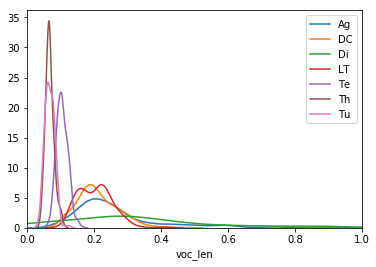

In [247]:
fig, ax = plt.subplots()
for vt in np.unique(wav_df.vocalization_type):
    vls = wav_df[wav_df.vocalization_type==vt]["voc_len"]
    sns.distplot(vls[vls < 4], label=vt, ax=ax, hist=False)
plt.legend()
ax.set_xlim([0,1])

### Create spectrograms

In [248]:
def prepare_mel_matrix(hparams, return_numpy=True):
    # create a filter to convolve with the spectrogram
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=hparams.num_mel_bins,
        num_spectrogram_bins=int(hparams.n_fft / 2) + 1,
        sample_rate=rate,
        lower_edge_hertz=hparams.mel_lower_edge_hertz,
        upper_edge_hertz=hparams.mel_upper_edge_hertz,
        dtype=tf.dtypes.float32,
        name=None,
    )
    
    # gets the center frequencies of mel bands
    mel_f = mel_frequencies(
        n_mels=hparams.num_mel_bins + 2,
        fmin=hparams.mel_lower_edge_hertz,
        fmax=hparams.mel_upper_edge_hertz,
    )

    # Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
    enorm = tf.dtypes.cast(
        tf.expand_dims(
            tf.constant(
                2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[: hparams.num_mel_bins])
            ),
            0,
        ),
        tf.float32,
    )

    mel_matrix = tf.multiply(mel_matrix, enorm)
    mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))
    if return_numpy:
        return mel_matrix.numpy()
    else:
        return mel_matrix

In [282]:
win_length_ms = 10
hop_length_ms = 2
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=1024,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-50,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=64,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=10000,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)
mel_matrix = prepare_mel_matrix(hparams)

441.0
88.2


In [283]:
wav_df[:3]

indv                 age recordingdate vocalization_type  \
0  BluRas07dd  AdultVocalizations    2011-06-07                Tu   
1  GraGra0201  AdultVocalizations    2011-09-07                Th   
3  LblRed0613  AdultVocalizations    2011-12-02                DC   

  voc_type_full voc_num                                            wav_loc  \
0          TukC      15  /mnt/cube/Datasets/ZebraFinch/VocalizationBank...   
1        ThuckC      47  /mnt/cube/Datasets/ZebraFinch/VocalizationBank...   
3            DC      31  /mnt/cube/Datasets/ZebraFinch/VocalizationBank...   

                                             vocdata   rate   voc_len  \
0  [[-14, 37], [-5, 55], [-22, 66], [-1, 88], [22...  44100  0.066689   
1  [[143, 115], [147, 84], [143, 78], [128, 116],...  44100  0.090930   
3  [[-106, -35], [-89, -52], [-108, -51], [-104, ...  44100  0.297914   

                                               specs  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...

In [284]:
audio = int16_to_float32(wav_df.vocdata.values[100][:,1])
audio = butter_bandpass_filter(audio, lowcut = 500, highcut=15000, fs=rate, order=4)
spectrogram = sg.spectrogram(audio, hparams)
mel_spec = np.dot(spectrogram.T, mel_matrix).T

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


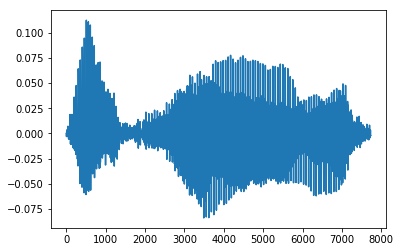

In [285]:
plt.plot(audio)
IPython.display.Audio(data=audio, rate=rate)

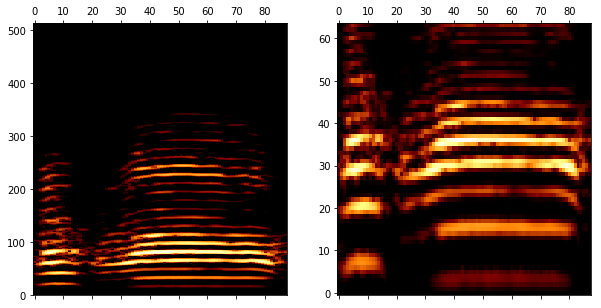

In [286]:
fig, axs = plt.subplots(ncols = 2, figsize=(10,5))
axs[0].matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
axs[1].matshow(mel_spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

### Make spectrogram dataset

In [287]:
from PIL import Image 
def log_resize_spec(spec, spec_len_mul=20, freq_bins = 64):
    resize_shape = [int(np.log(np.shape(spec)[1])*spec_len_mul), freq_bins]
    resize_spec = np.array(Image.fromarray(spec).resize(resize_shape, Image.ANTIALIAS))
    return resize_spec

def pad_spectrogram(spectrogram, pad_length):
    """ Pads a spectrogram to being a certain length
    """
    excess_needed = pad_length - np.shape(spectrogram)[1]
    pad_left = np.floor(float(excess_needed) / 2).astype("int")
    pad_right = np.ceil(float(excess_needed) / 2).astype("int")
    return np.pad(
        spectrogram, [(0, 0), (pad_left, pad_right)], "constant", constant_values=0
    )

def make_spec(data, hparams):
    spectrogram = sg.spectrogram(data, hparams)
    #spectrogram = mask_spec(spectrogram)
    spectrogram = spectrogram/np.max(spectrogram)
    #return spectrogram
    mel_spec = np.dot(spectrogram.T, mel_matrix).T
    #mel_spec = mask_spec(mel_spec)
    mel_spec = log_resize_spec(mel_spec)
    mel_spec[mel_spec<0] = 0
    mel_spec = mel_spec/np.max(mel_spec)
    mel_spec = (mel_spec * 255).astype('uint8')
    return mel_spec

def mask_spec(spec, spec_thresh=.9, offset=1e-10):
    mask = spec >= (spec.max(axis=0,keepdims=1)*spec_thresh+offset)
    return spec*mask

In [288]:
spec = make_spec(int16_to_float32(wav_df.vocdata.values[100])[:,0], hparams)

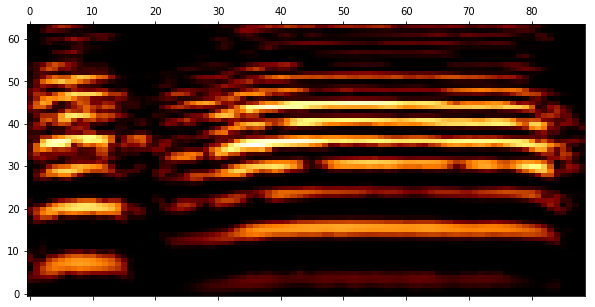

In [289]:
fig, ax = plt.subplots(ncols = 1, figsize=(10,5))
ax.matshow(spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [290]:
with Parallel(n_jobs=24, verbose=verbosity) as parallel:
    specs = parallel(
        delayed(make_spec)(int16_to_float32(row.vocdata[:,0]), hparams)
        for idx, row in tqdm(
            wav_df.iterrows(), total = len(wav_df)
        )
    )

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  96 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 2160 out of 2160 | elapsed:    1.5s finished


In [291]:
spec_lens = np.array([np.shape(i)[1] for i in specs])

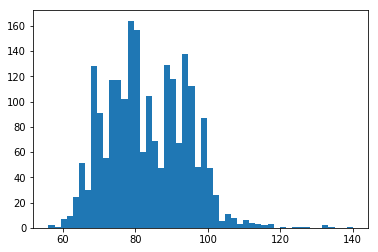

In [292]:
plt.hist(spec_lens, bins=50);

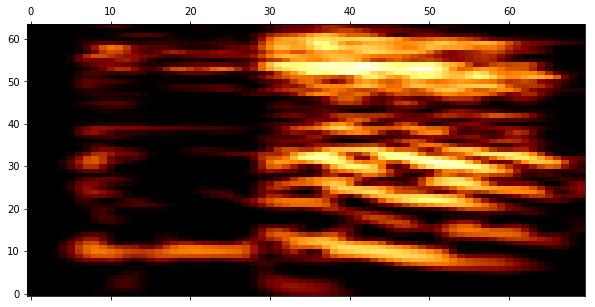

In [293]:
fig, ax = plt.subplots(ncols = 1, figsize=(10,5))
ax.matshow(specs[0], origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [294]:
def pad_spectrogram(spectrogram, pad_length):
    """ Pads a spectrogram to being a certain length
    """
    excess_needed = pad_length - np.shape(spectrogram)[1]
    pad_left = np.floor(float(excess_needed) / 2).astype("int")
    pad_right = np.ceil(float(excess_needed) / 2).astype("int")
    return np.pad(
        spectrogram, [(0, 0), (pad_left, pad_right)], "constant", constant_values=0
    )

In [295]:
with Parallel(n_jobs=24, verbose=verbosity) as parallel:
    specs_padded = parallel(
        delayed(pad_spectrogram)(spec, np.max(spec_lens))
        for spec in tqdm(
            specs
        )
    )

[Parallel(n_jobs=24)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  86 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 2160 out of 2160 | elapsed:    0.3s finished


In [296]:
wav_df['specs'] = specs_padded

In [297]:
spec = specs_padded[100]

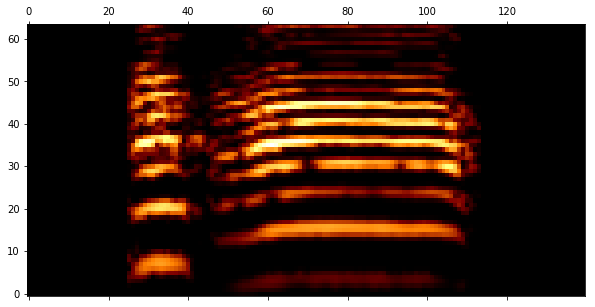

In [298]:
fig, ax = plt.subplots(ncols = 1, figsize=(10,5))
ax.matshow(spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [299]:
def plot_voc_canvas(specs_padded, nrow = 6, ncol = 20, zoom = 2):
    """
    """
    dimx = np.shape(specs_padded[0])[0]
    dimy = np.shape(specs_padded[0])[1]

    canvas = np.zeros((nrow*dimx, ncol*dimy))
    cn = 0
    for row in range(nrow)[::-1]:
        for col in range(ncol):
            canvas[dimx*row:dimx*(row+1), dimy*col:dimy*(col+1)] = specs_padded[cn]
            cn += 1

    fig, ax = plt.subplots(figsize=(ncol*zoom*2, nrow*zoom))
    ax.matshow(canvas, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
    ax.axis('off')
    plt.show()

In [300]:
wav_df[:3]

indv                 age recordingdate vocalization_type  \
0  BluRas07dd  AdultVocalizations    2011-06-07                Tu   
1  GraGra0201  AdultVocalizations    2011-09-07                Th   
3  LblRed0613  AdultVocalizations    2011-12-02                DC   

  voc_type_full voc_num                                            wav_loc  \
0          TukC      15  /mnt/cube/Datasets/ZebraFinch/VocalizationBank...   
1        ThuckC      47  /mnt/cube/Datasets/ZebraFinch/VocalizationBank...   
3            DC      31  /mnt/cube/Datasets/ZebraFinch/VocalizationBank...   

                                             vocdata   rate   voc_len  \
0  [[-14, 37], [-5, 55], [-22, 66], [-1, 88], [22...  44100  0.066689   
1  [[143, 115], [147, 84], [143, 78], [128, 116],...  44100  0.090930   
3  [[-106, -35], [-89, -52], [-108, -51], [-104, ...  44100  0.297914   

                                               specs  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...

BlaBla0506 46


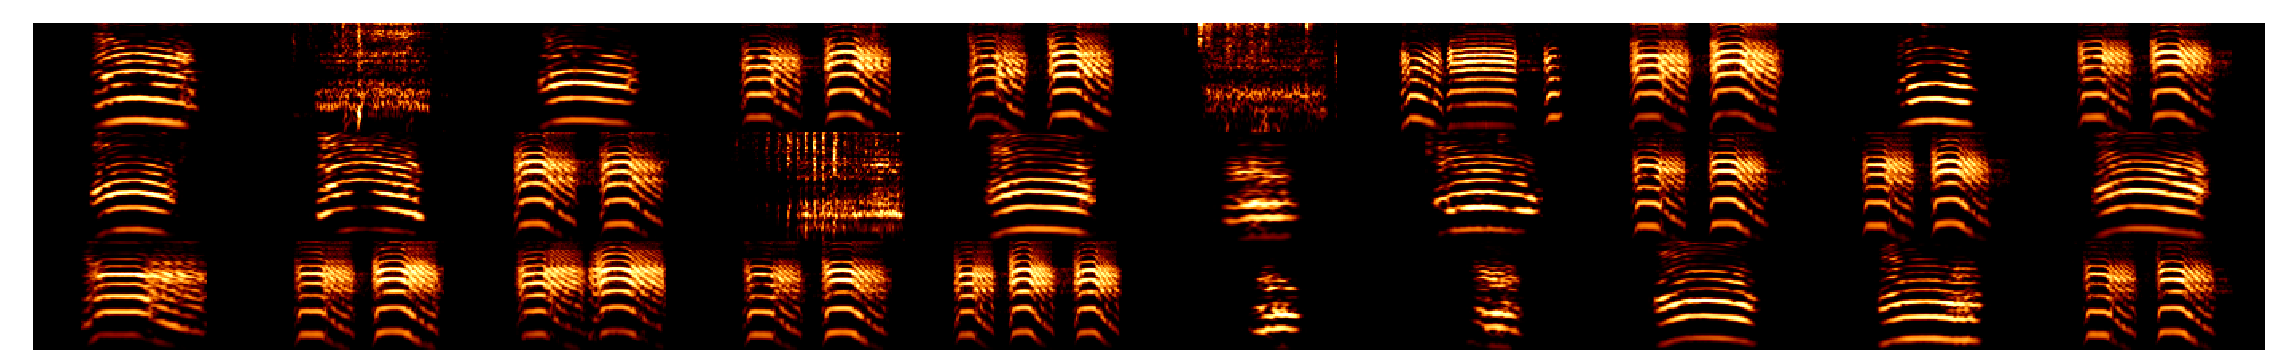

BlaLbl8026 60


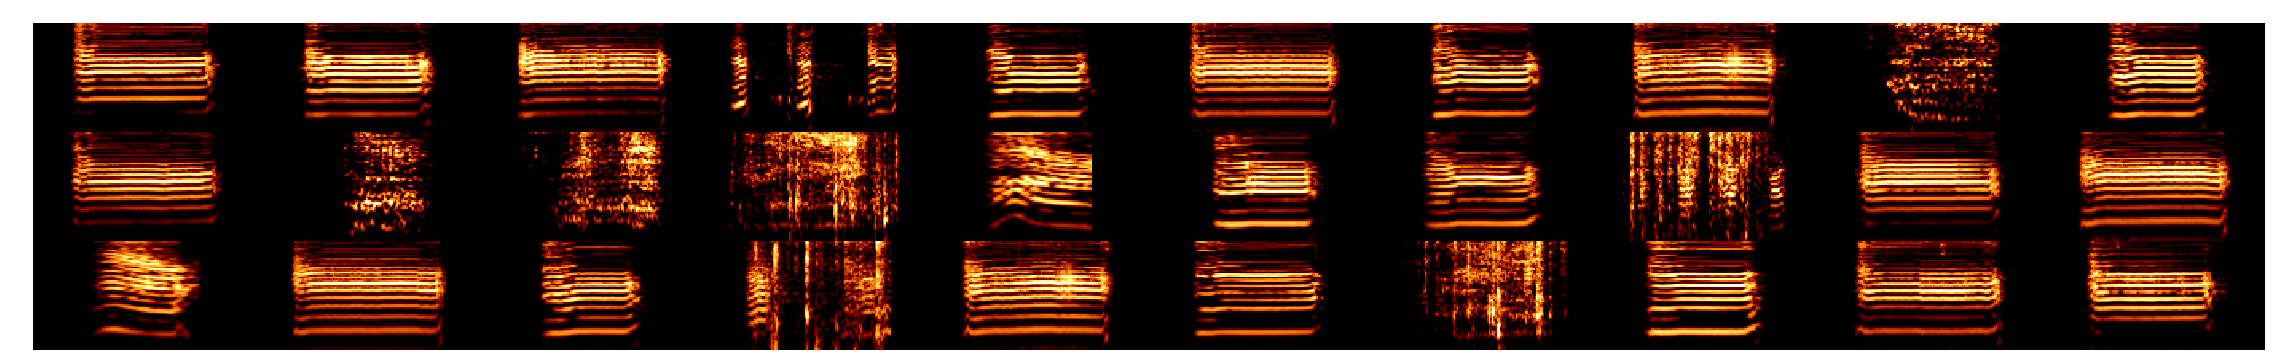

BluRas07dd 80


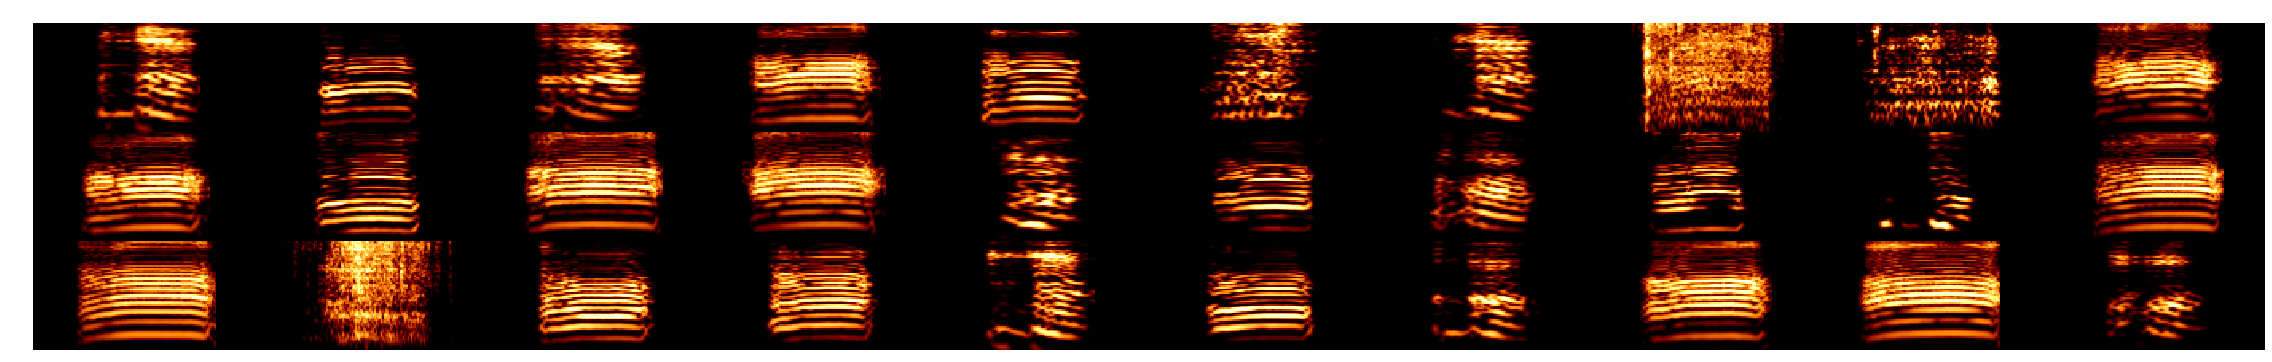

BluRas61dd 84


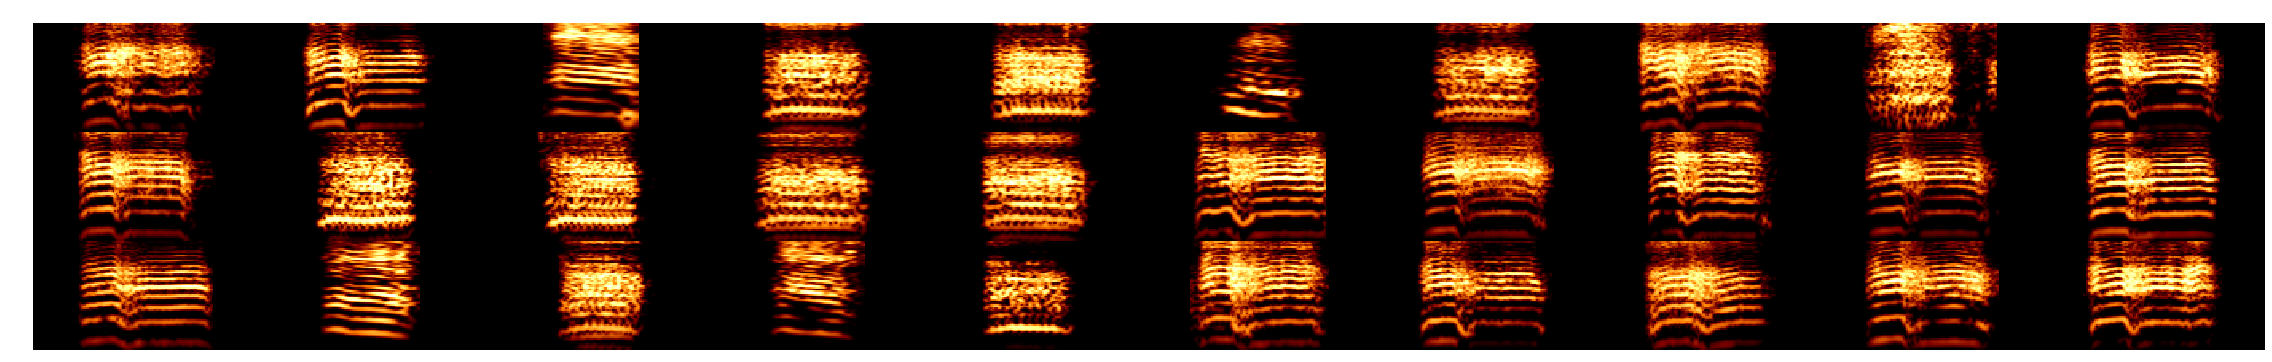

GraGra0201 158


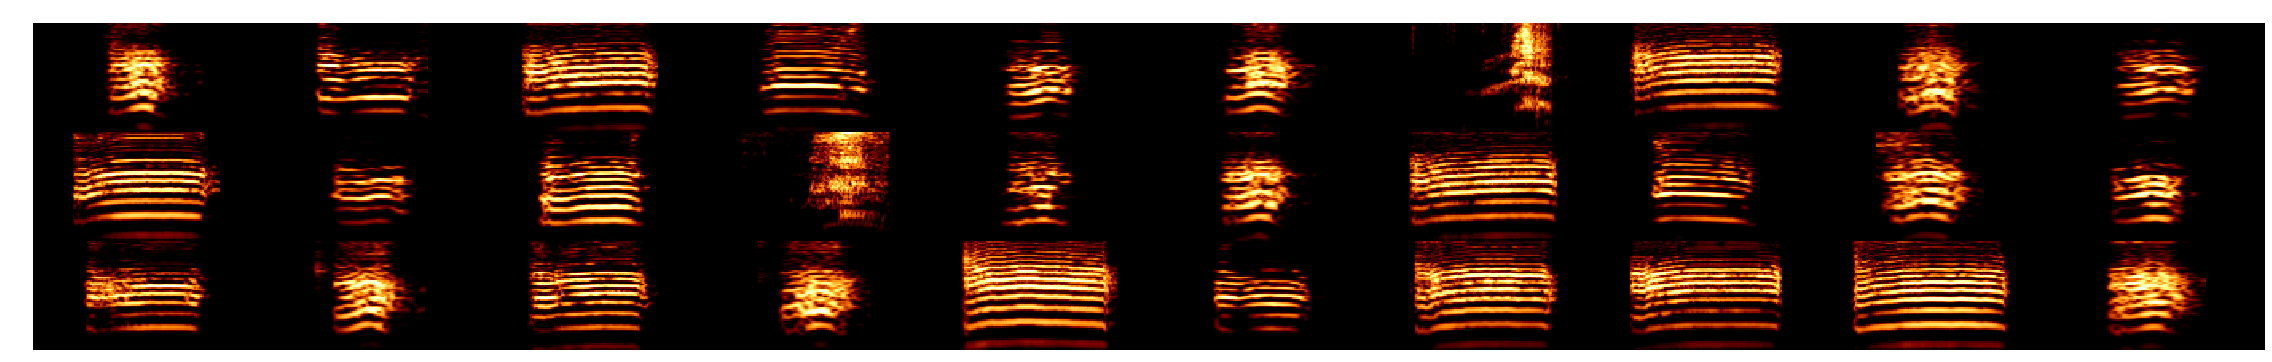

GraLbl0457 71


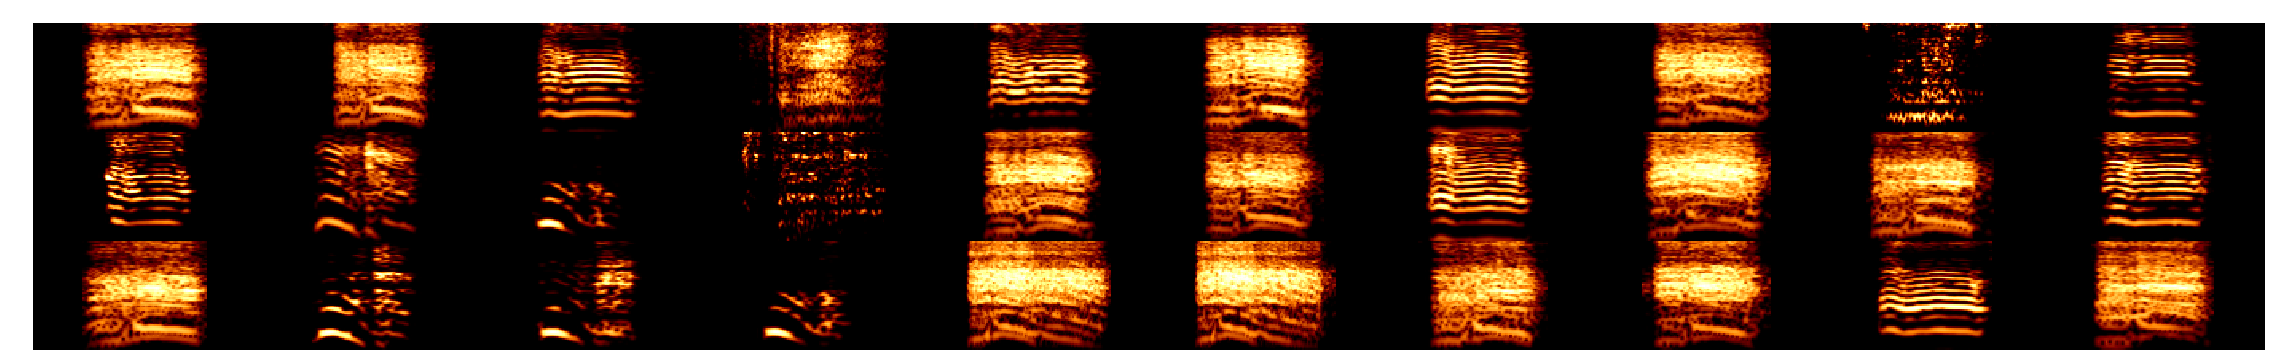

GreGre2522 36


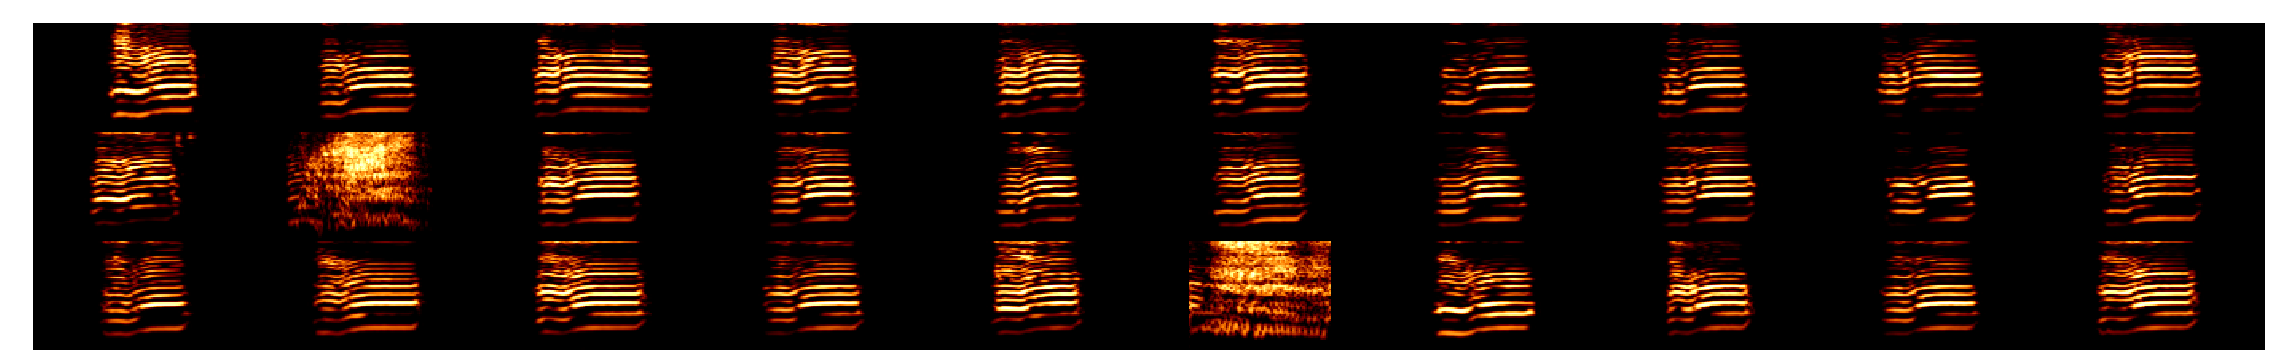

GreGre6364 43


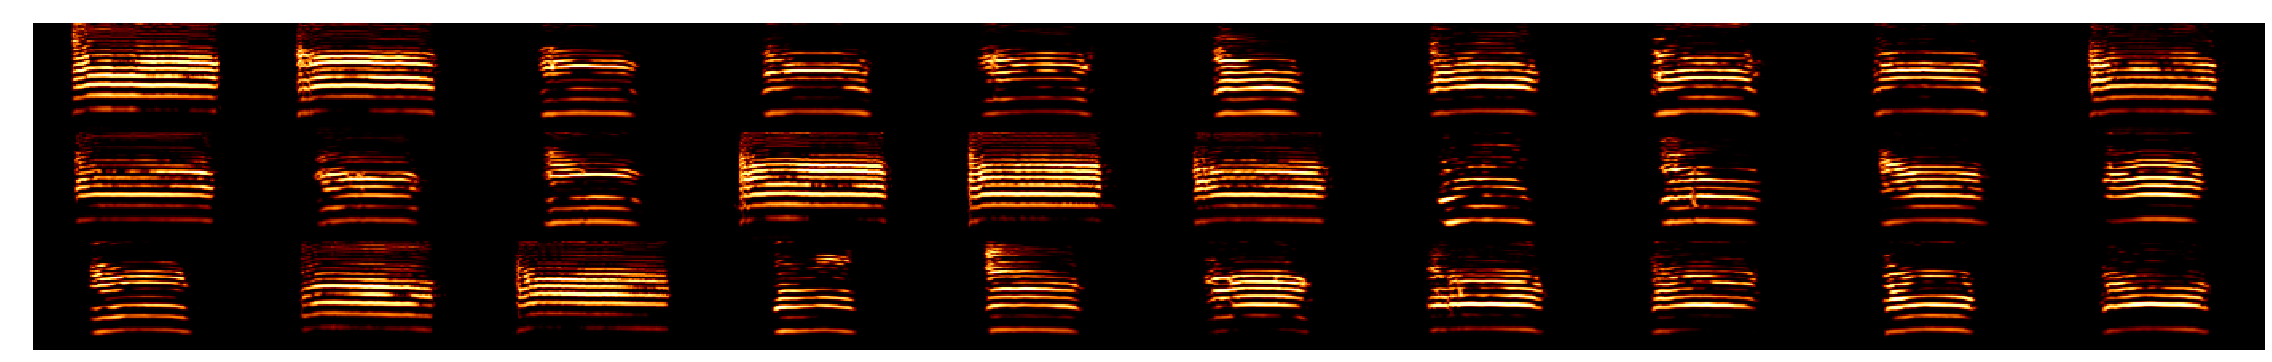

GreOra1817 131


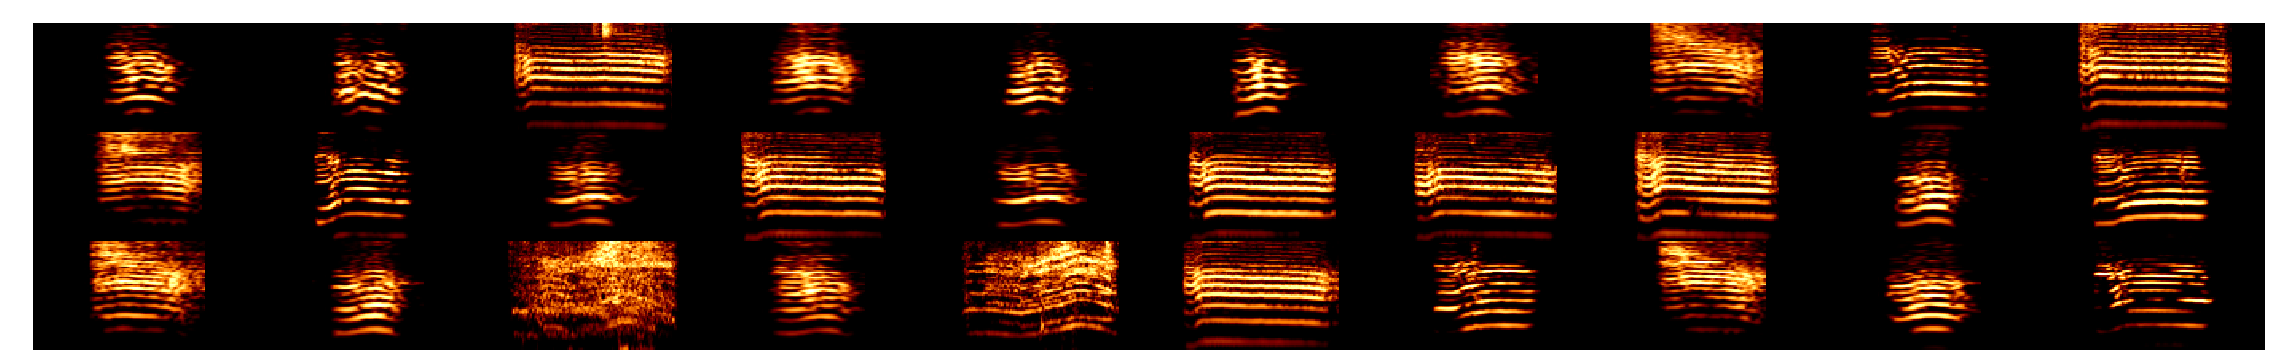

GreRas2400 36


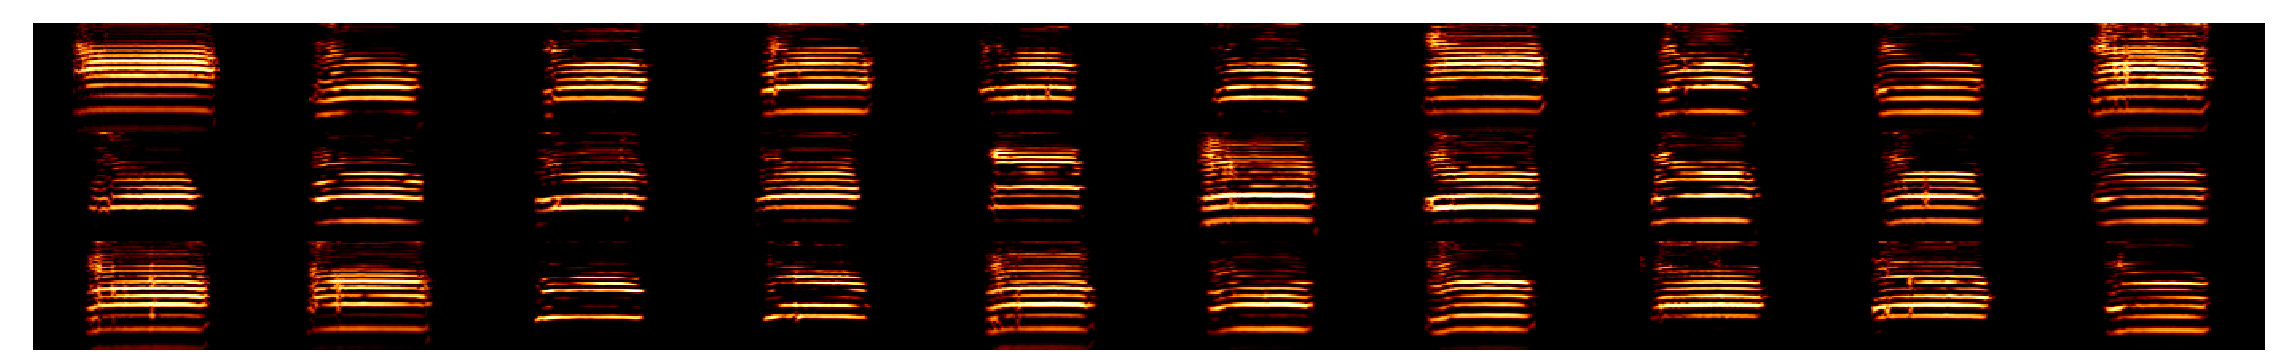

GreWhi1242 30


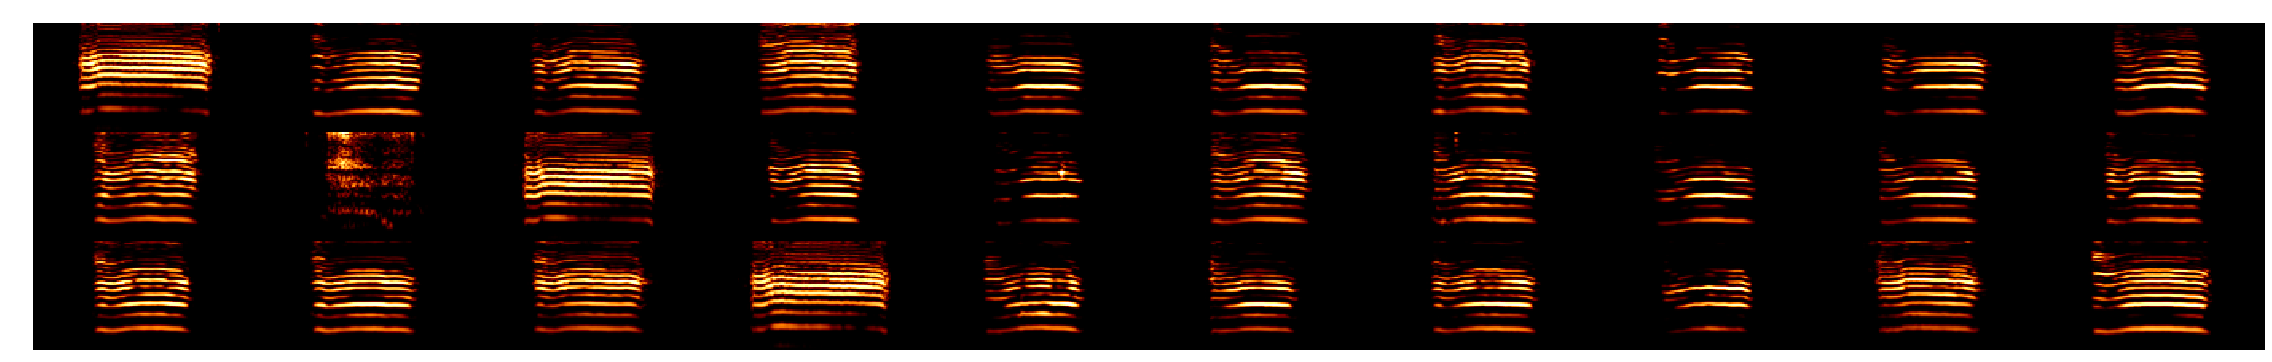

HPiHPi4748 152


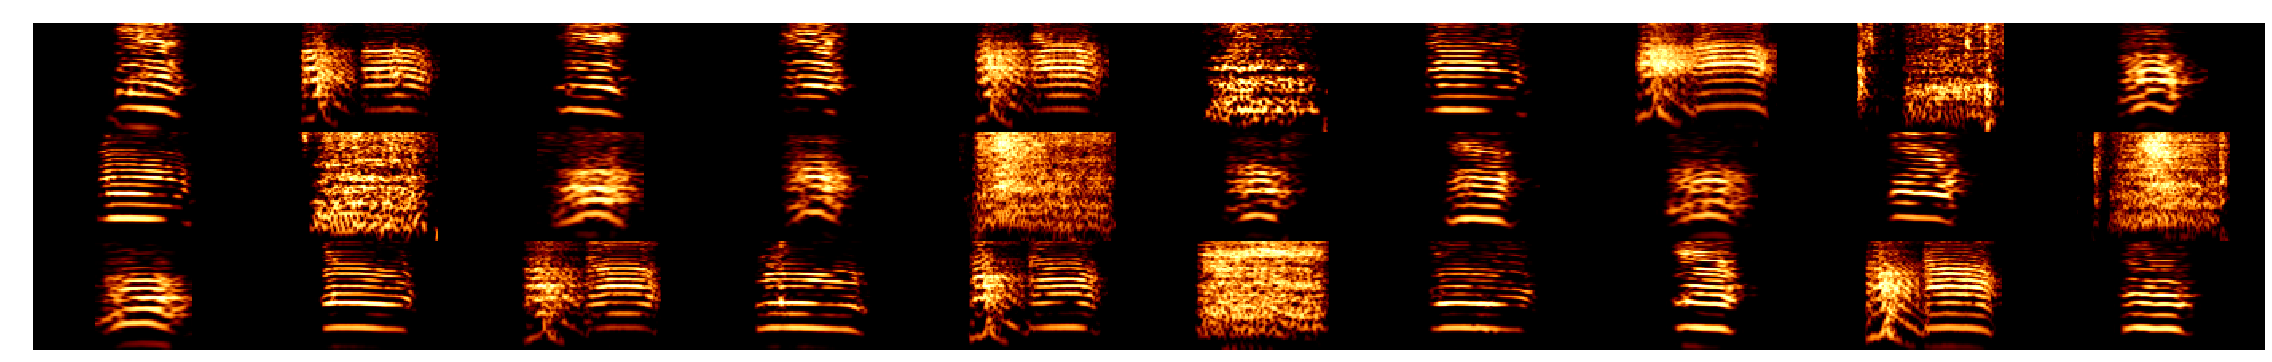

LblBla4419 43


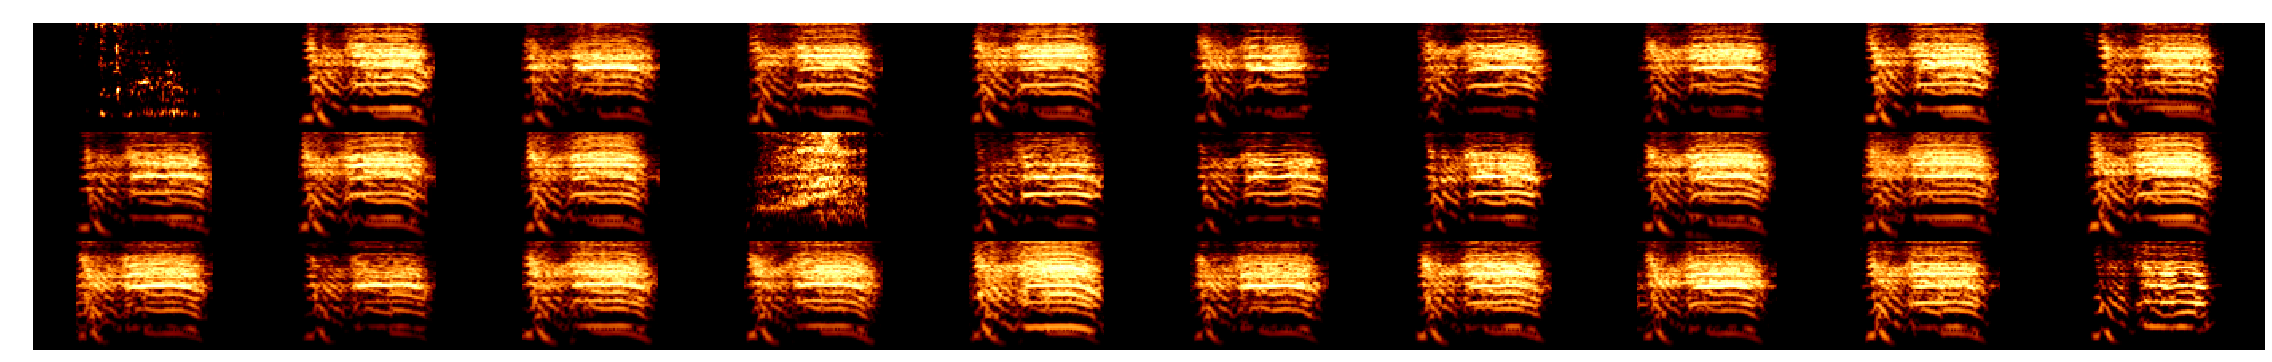

LblBla4548 81


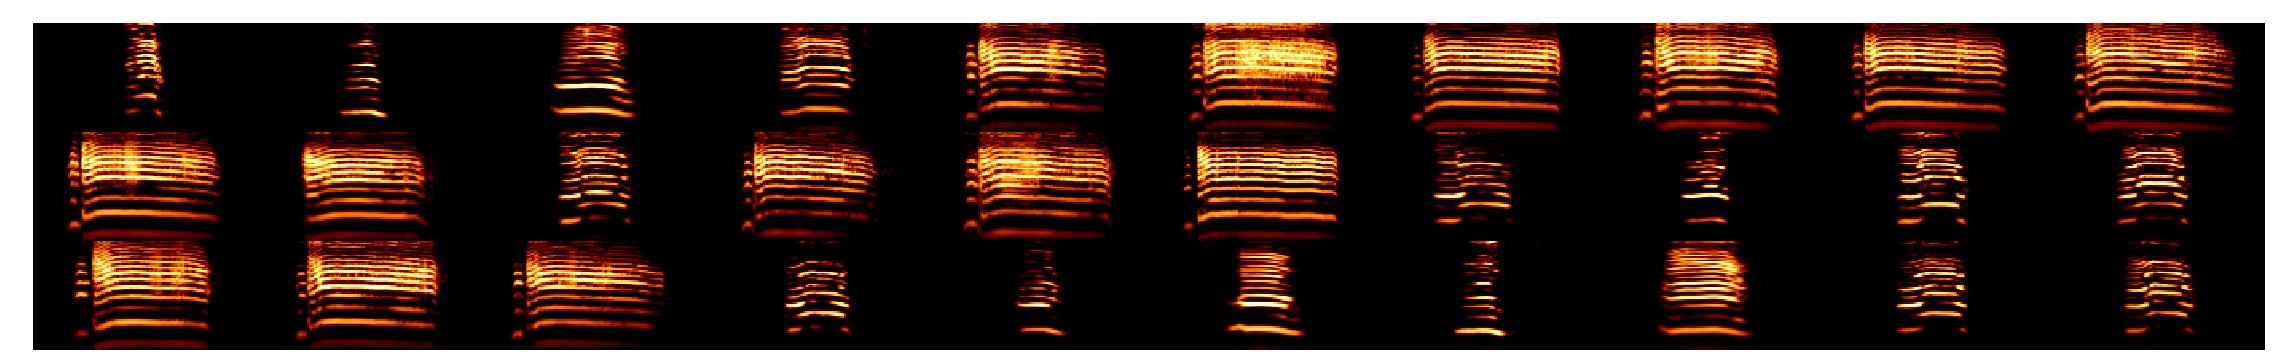

LblRed0613 107


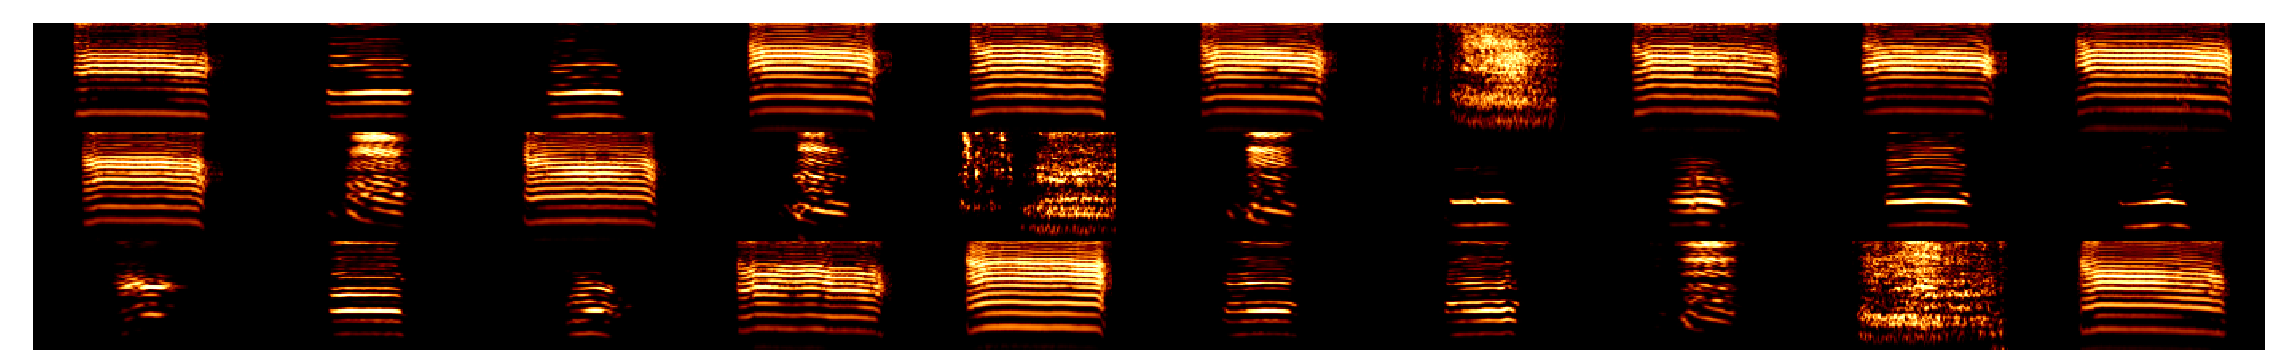

PurRas20dd 78


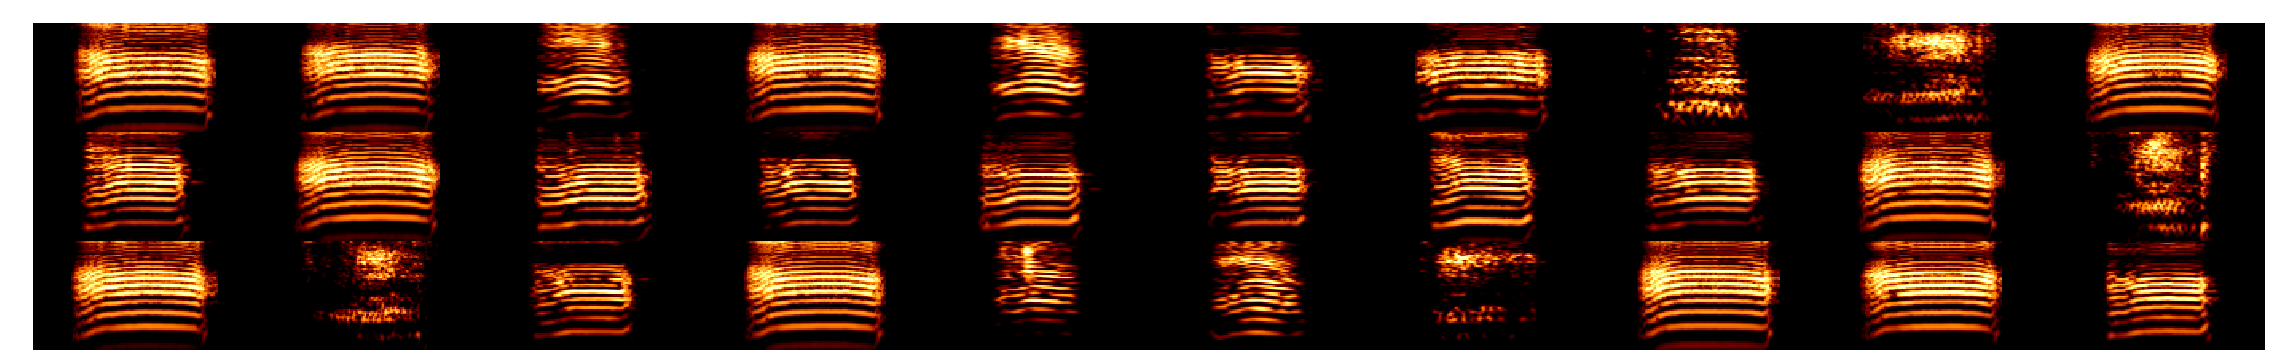

WhiBlu4818 32


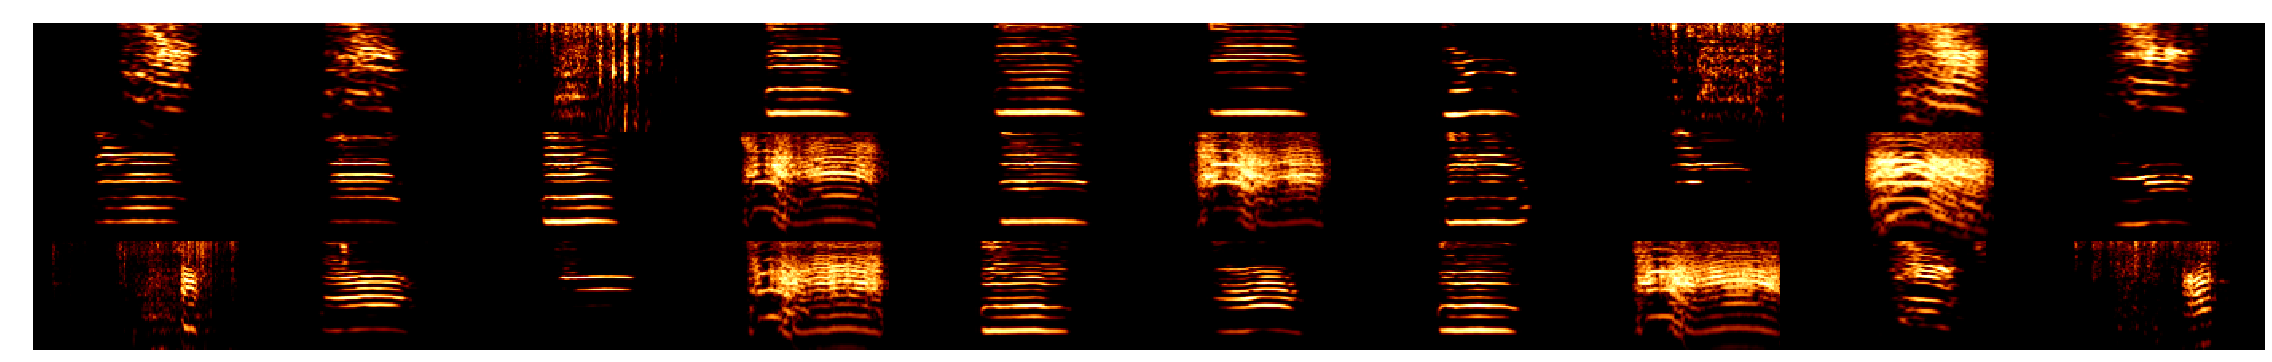

WhiBlu4917 36


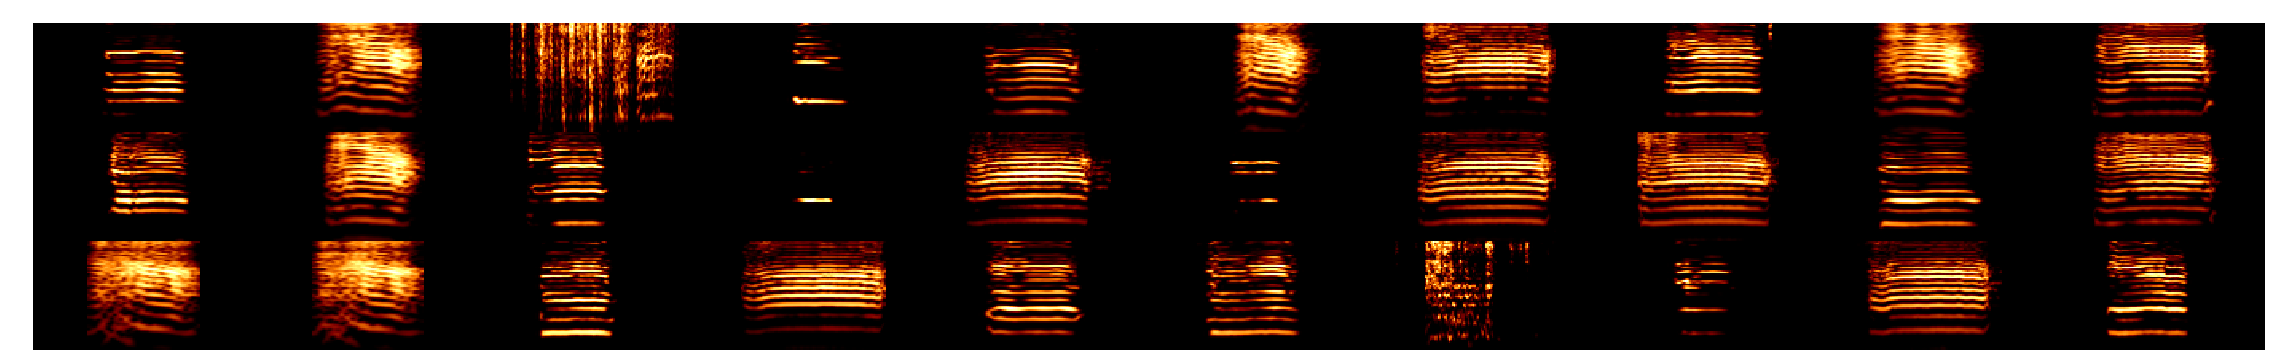

WhiBlu5698 42


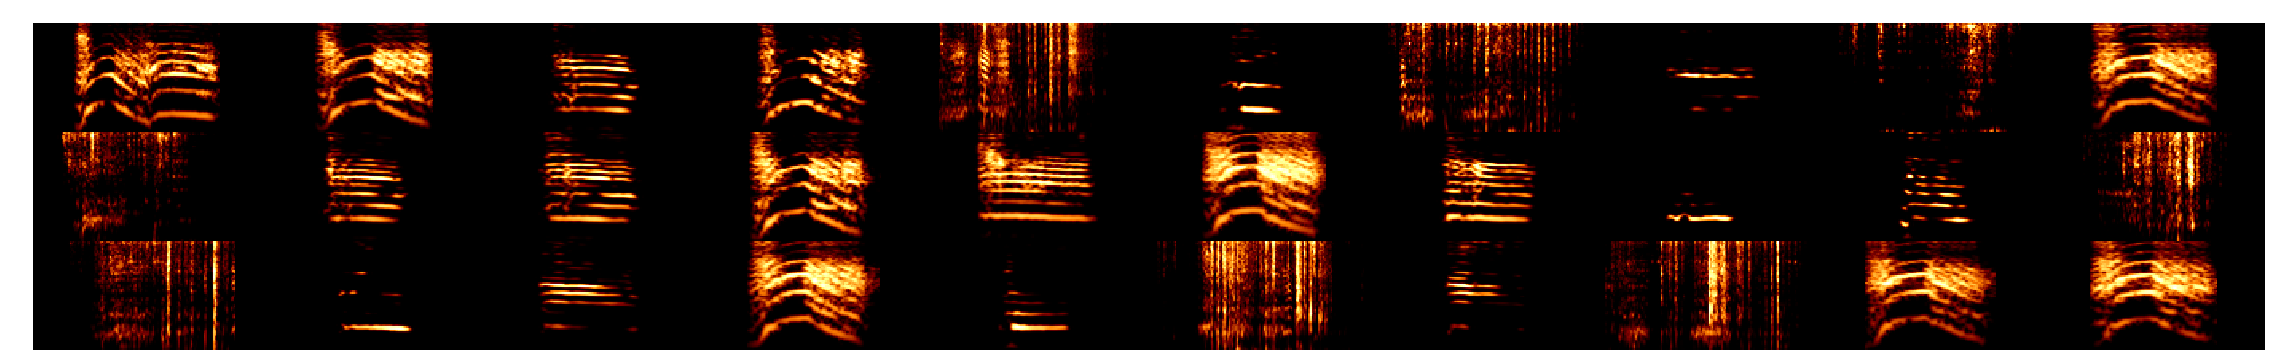

WhiLbl0010 95


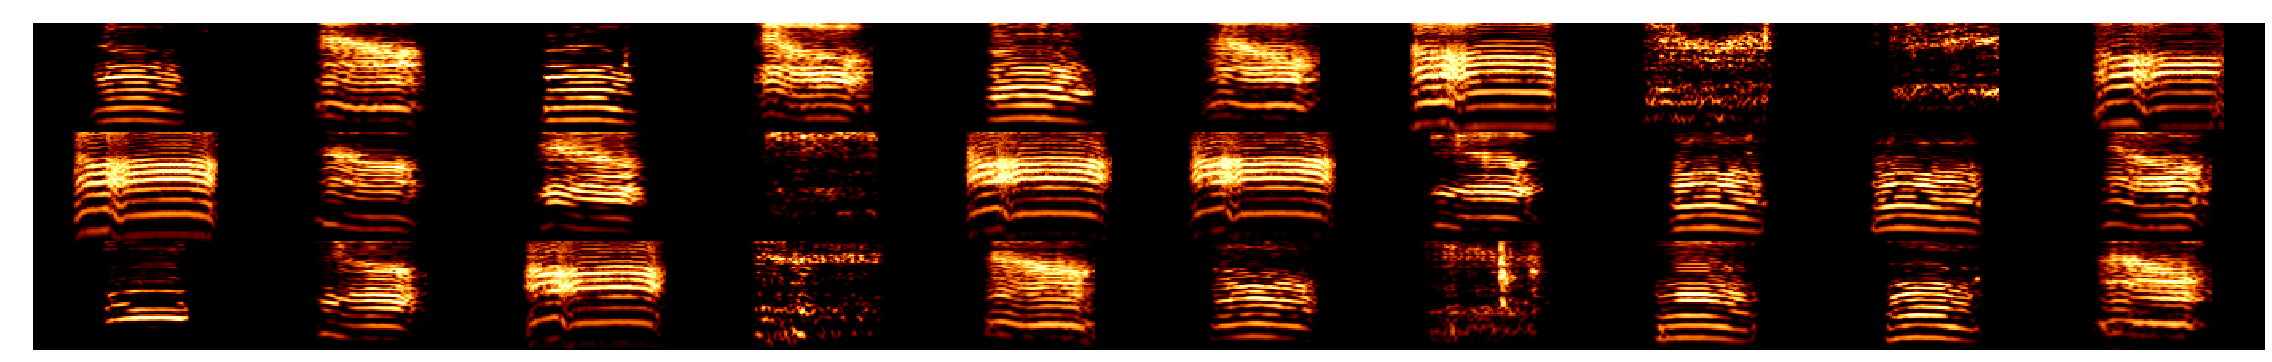

WhiRas44dd 140


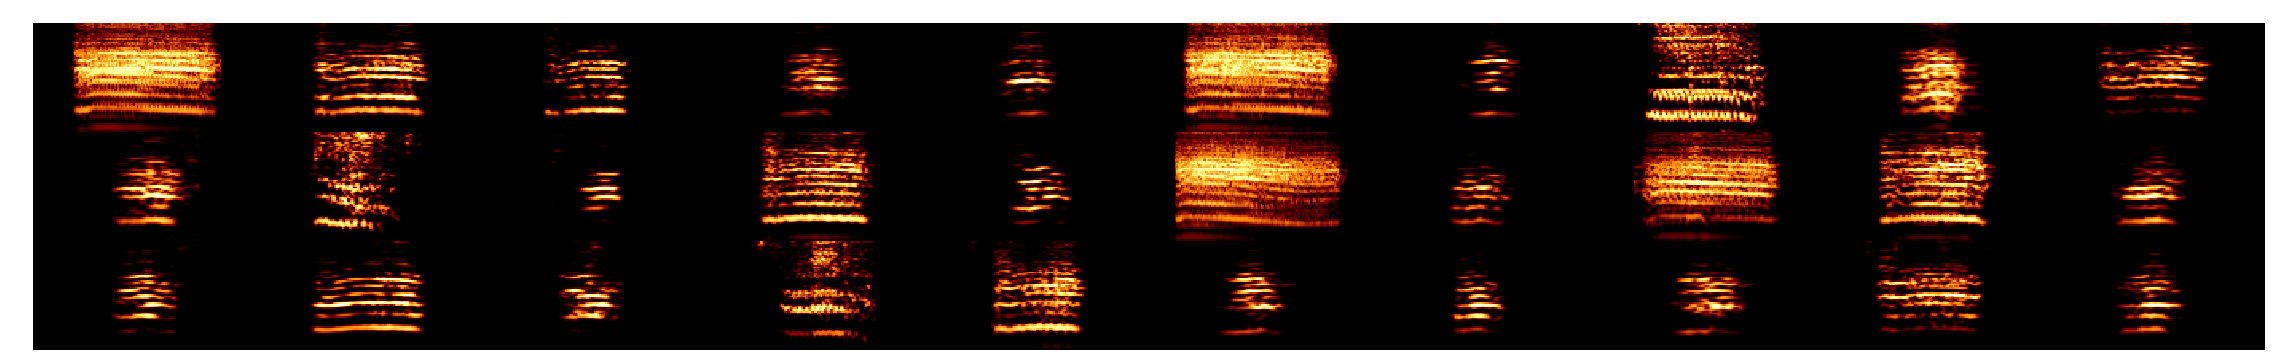

WhiWhi1415 55


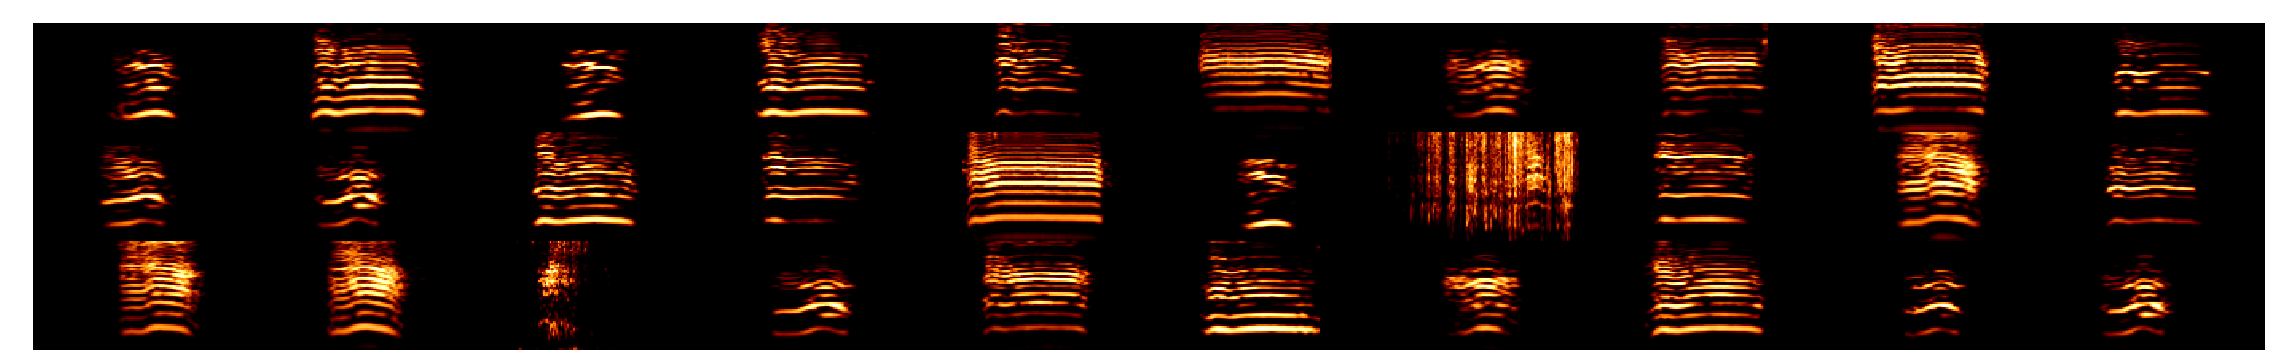

YelGre5275 151


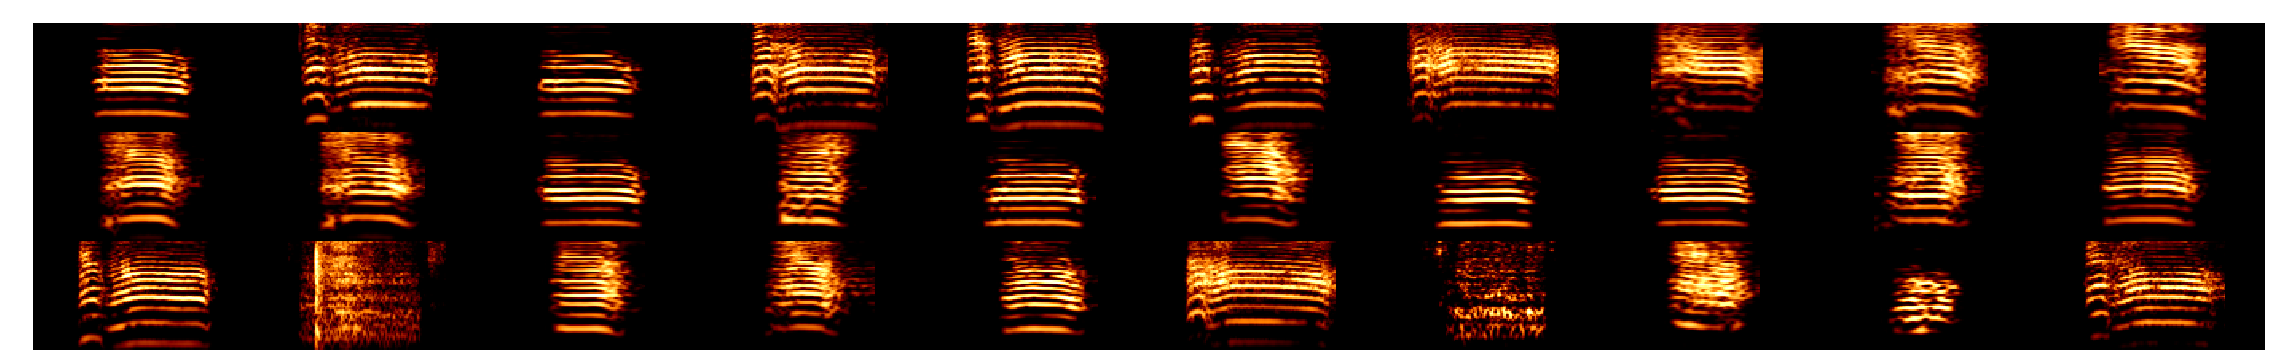

YelOra2575 108


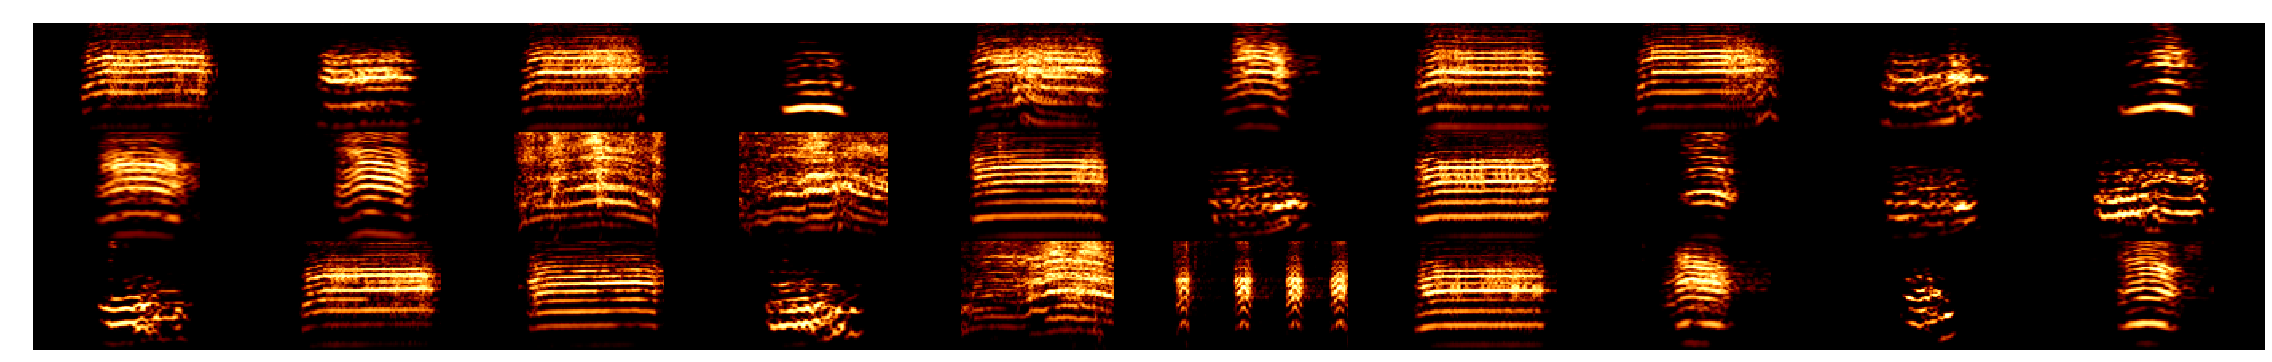

In [301]:
nrow =3;ncol=10
for indv in np.unique(wav_df.indv):
    indv_df = wav_df[
        (wav_df.indv == indv)
        #$ (wav_df.vocalization_type == 'So')        
    ]
    if len(indv_df) < nrow*ncol: 
        continue
    print(indv, len(indv_df))
    plot_voc_canvas(indv_df.specs.values, nrow=nrow, ncol=ncol)

Wsst or aggressive call 196


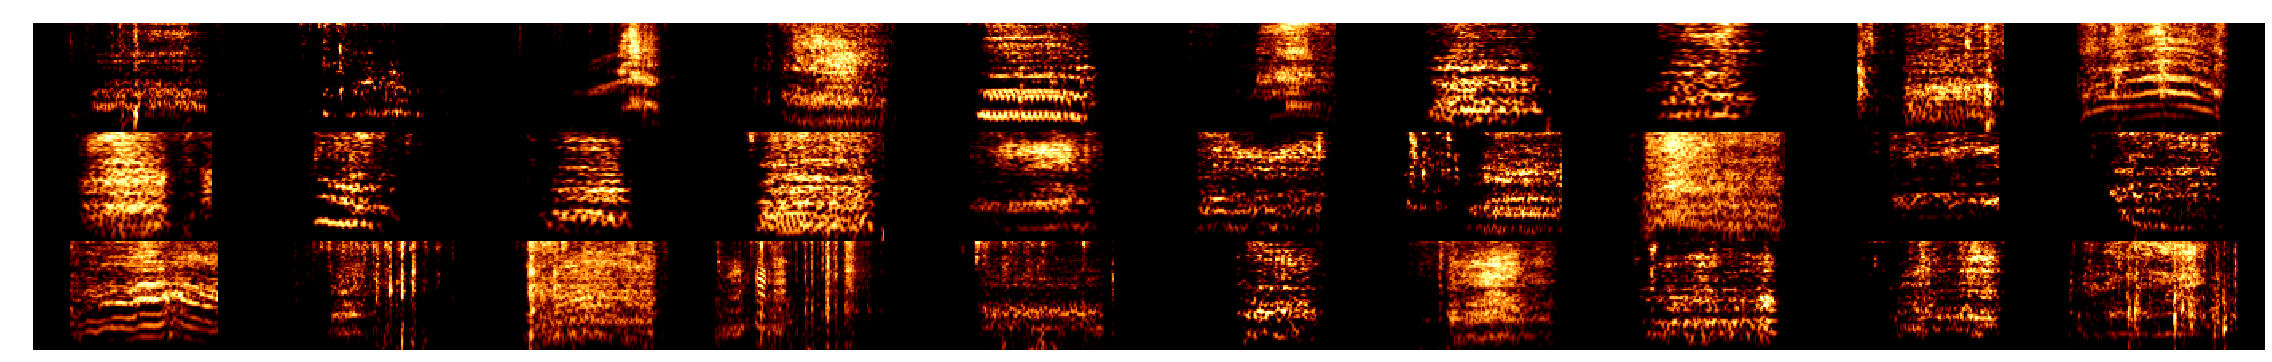

Distance call 585


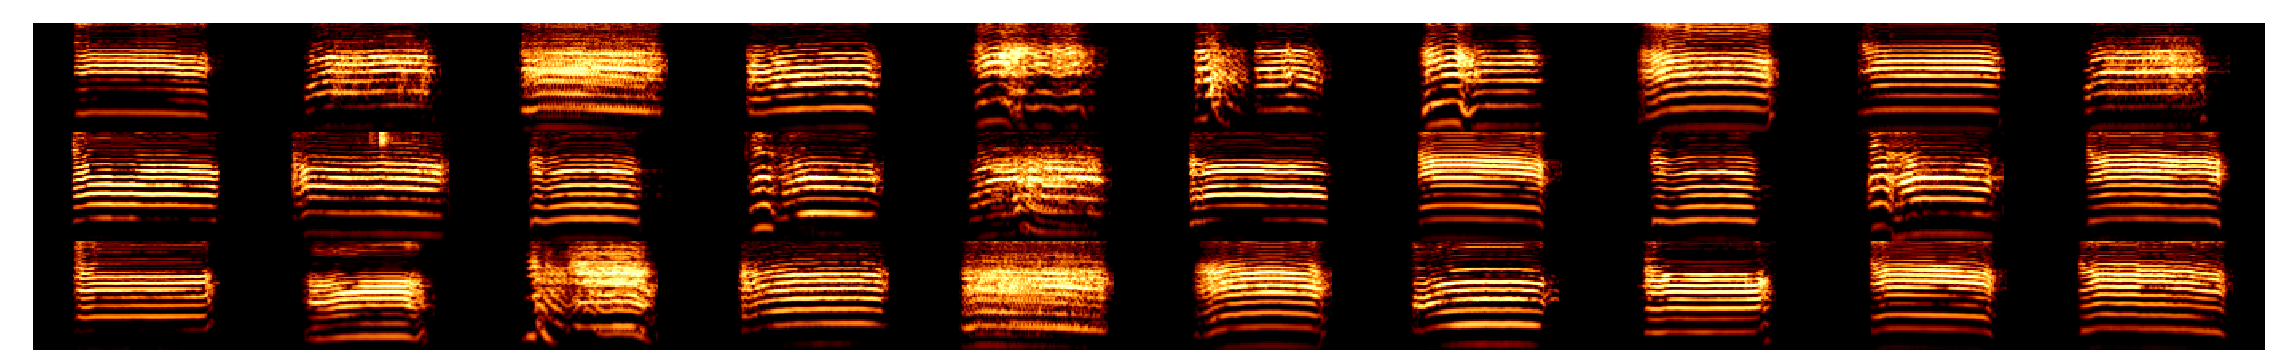

Long Tonal call 231


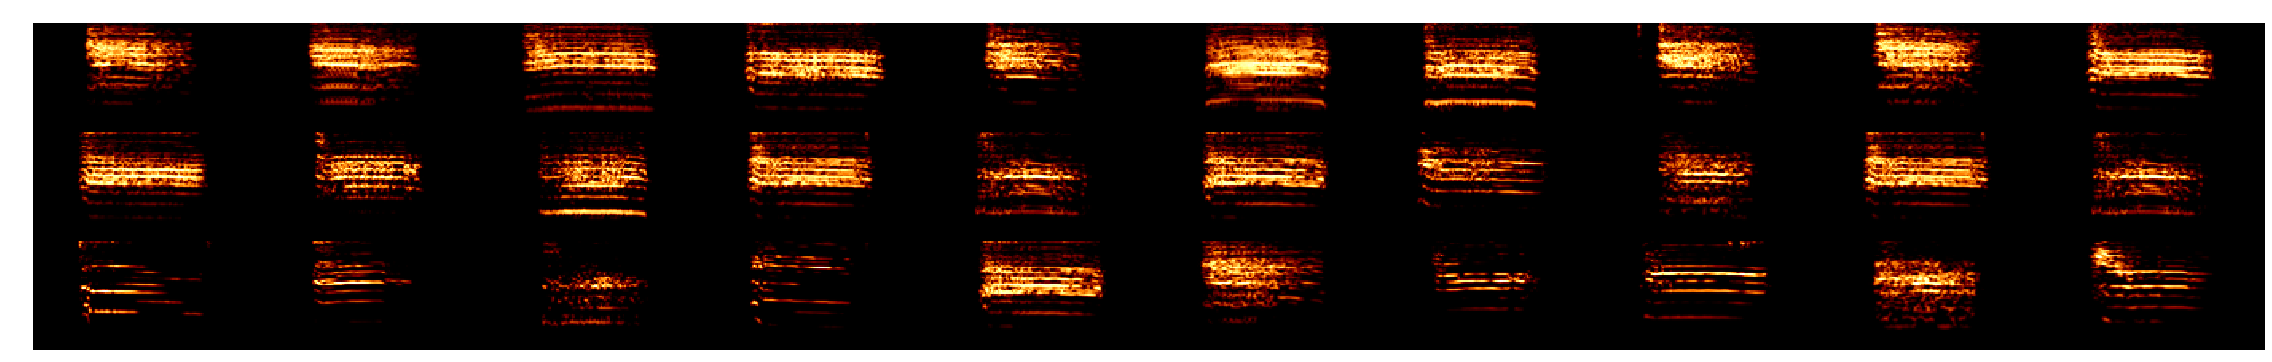

Tet call 613


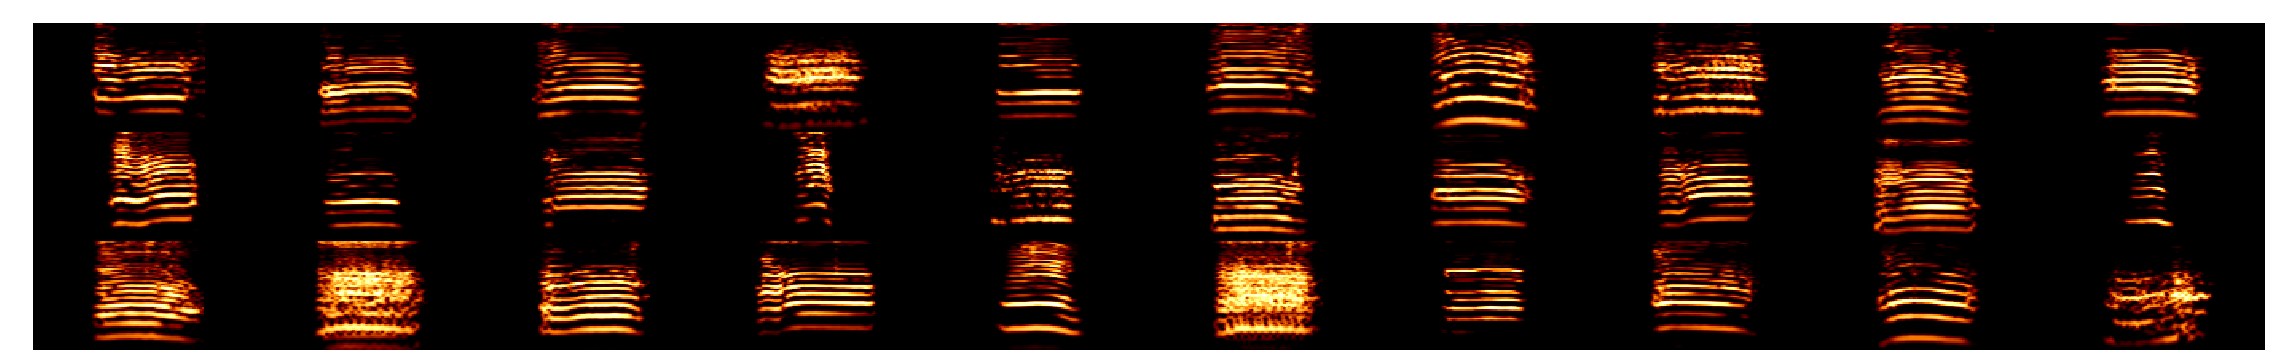

Thuk call 279


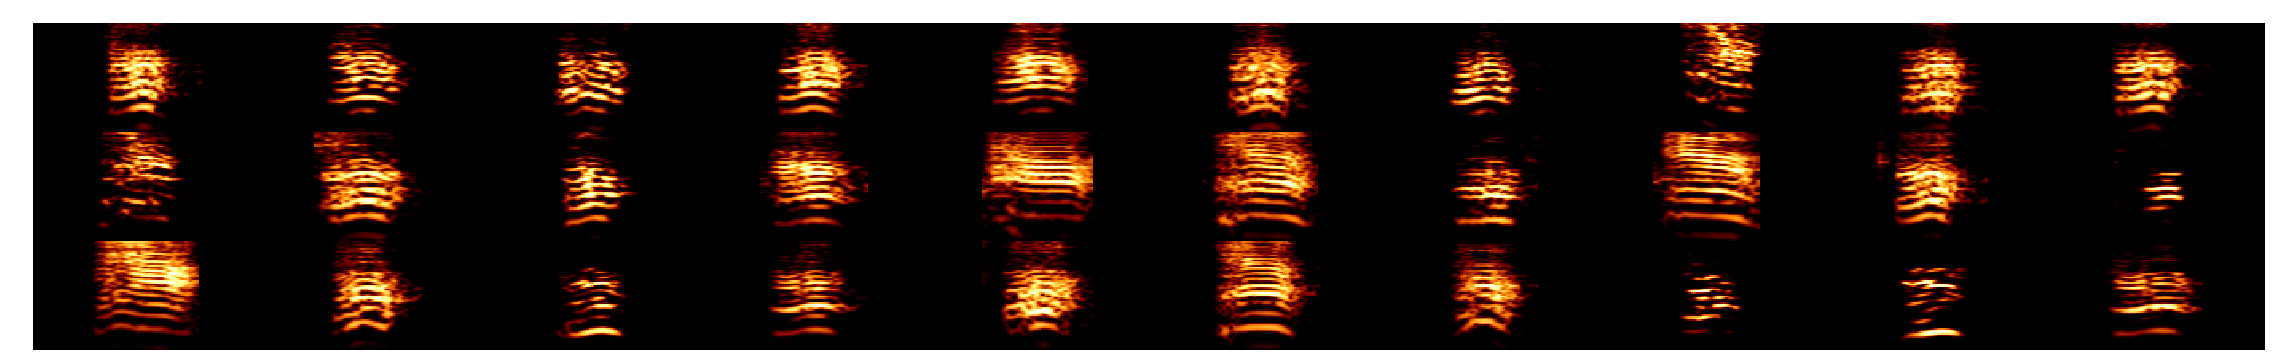

Tuck call 240


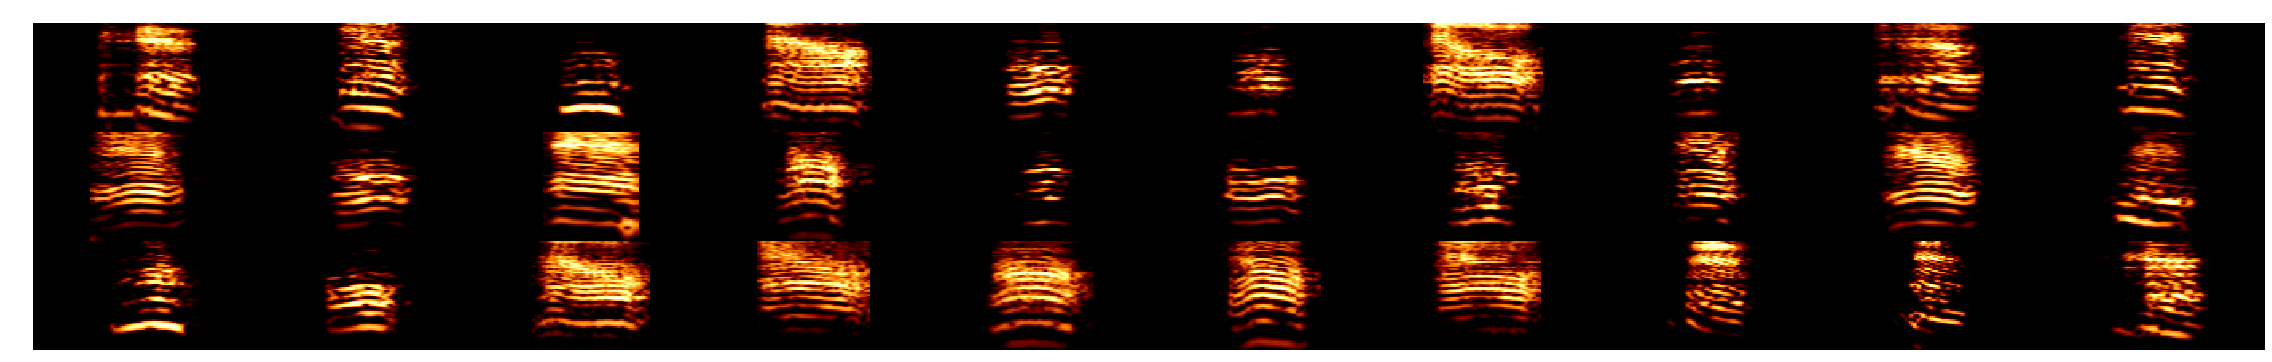

In [302]:
nrow =3;ncol=10
for vocalization_type in np.unique(wav_df.vocalization_type):
    vocalization_type_df = wav_df[
        (wav_df.vocalization_type == vocalization_type)
        #$ (wav_df.vocalization_type == 'So')        
    ]
    if len(vocalization_type_df) < nrow*ncol: 
        continue
    print(call_dict[vocalization_type], len(vocalization_type_df))
    plot_voc_canvas(vocalization_type_df.specs.values, nrow=nrow, ncol=ncol)

### UMAP

In [303]:
import umap
import seaborn as sns

In [304]:
specs = np.stack(wav_df.specs.values, axis=2).T
specs_flattened = np.reshape(specs, (np.shape(specs)[0], np.prod(np.shape(specs)[1:])))
len(specs_flattened)

2160

In [305]:
fit = umap.UMAP(min_dist=0.5)
%time u_all = fit.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


CPU times: user 13.7 s, sys: 972 ms, total: 14.7 s
Wall time: 6.73 s


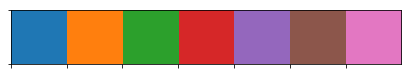

In [306]:
labs = wav_df.vocalization_type.values
pal = sns.color_palette(n_colors=len(np.unique(labs)))
sns.palplot(pal)
lab_dict = {lab:pal[i] for i, lab in enumerate(np.unique(labs))}
colors = np.array([lab_dict[i] for i in labs])

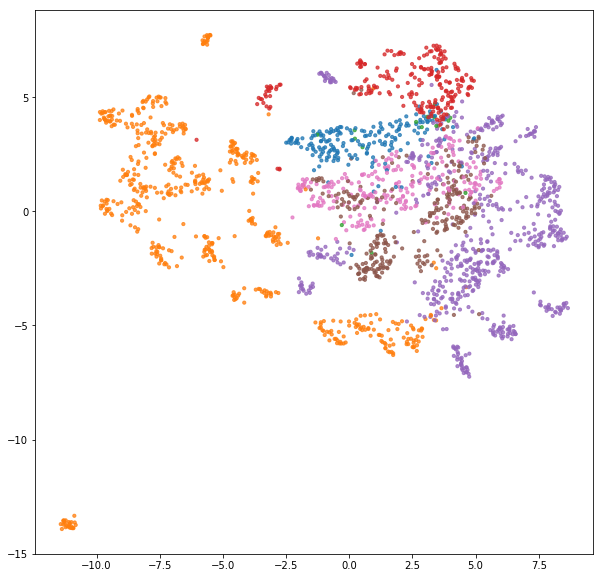

In [307]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(u_all[:,0], u_all[:,1], alpha = 0.75, s=10, color=colors)